# Curve fitting resources

- https://www.youtube.com/watch?v=Jl-Ye38qkRc
- https://www.youtube.com/watch?v=4vryPwLtjIY

### TODO
- Try classification

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from glob import glob

from keras.models import load_model

import matplotlib
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Make all python scripts available in the path
import sys
sys.path.append('../')

In [3]:
import lrn_crv

In [4]:
filepath = Path(os.getcwd())
filepath

PosixPath('/vol/ml/apartin/projects/LearningCurves/notebooks')

In [5]:
# Results dir
maindir = filepath / '../top6_trn'

# Utils

In [6]:
def load_scores(run_dir, metric_name='mean_absolute_error', cv_folds=5):
    """ Load scores from the scores master table into a format that is consistent
    with the output of sklearn's function learning_curve(). That results in a list
    of 3 arrays: data sizes, scores of training set, scores of val set.
    """
    scores_df = pd.read_csv(run_dir/'lrn_crv_scores.csv')
    df = scores_df.loc[scores_df['tr_set']==False] # only val scores
    
    data_sizes = sorted(df['tr_size'].unique())
    aa = df[df['metric']==metric_name].reset_index(drop=True)
    aa.sort_values('tr_size', inplace=True)

    tr = aa[aa['tr_set']==True]
    vl = aa[aa['tr_set']==False]

    tr = tr.iloc[:, -cv_folds:]
    vl = vl.iloc[:, -cv_folds:]

    rslt = []
    rslt.append(data_sizes)
    rslt.append(tr.values if tr.values.shape[0]>0 else None)
    rslt.append(vl.values if vl.values.shape[0]>0 else None)

    return rslt, scores_df

In [7]:
def get_xy(scores, metric_name='mean_absolute_error'):
    """ Get x and y from scores (for specific run). """
    dd = scores
    dd = dd[dd['metric']==metric_name]
    dd = dd[dd['tr_set']==False]
    dd.reset_index(drop=True, inplace=True)
    dd.drop(columns=['metric', 'tr_set'], inplace=True)
    
    x = dd.tr_size.values
    y = dd.iloc[:,1:].mean(axis=1).values
    return x, y

In [79]:
# Same metric for different runs
def plot_all_metrics_from_runs(runs, metrics='all', title=None, figsize=(20,18), save=False,
                               xtick_scale:str='log2', ytick_scale:str='log2'):
    """ ... """
    if metrics=='all':
        tmp = pd.read_csv(runs['run1'][1])
        metrics = tmp['metric'].unique()

    colors = ['b', 'r', 'k', 'c', 'm', 'g']
    # title = None
    fontsize=14

    ncols=2
    nrows=int(np.ceil(len(set(metrics))/ncols))
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    ax = ax.ravel()

    # Iterate over metrics
    for i, metric_name in enumerate(metrics):

        for j, (k, v) in enumerate(runs.items()):
            df = pd.read_csv(runs[k][1])
            cvf = len([c for c in df.columns.tolist() if c[0]=='f']) # get the number of cv_folds

            dfm = df[df['metric']==metric_name].reset_index(drop=True)  # scores for a specific metric 

            tr_sizes  = dfm['tr_size'].unique()
            te_scores = dfm.loc[dfm['tr_set']==False, dfm.columns[-cvf:]]

            te_scores_mean = np.mean(te_scores, axis=1)
            te_scores_std  = np.std(te_scores, axis=1)

            # --------------------------------------
            # Plot learning curve
            # --------------------------------------
            # linestype = dd[ runs[k][0].split('_')[-1] ]
            # ax[i].plot(tr_sizes, te_scores_mean, marker='.', linestyle=linestype, color=colors[j], label=runs[k][0])
            ax[i].plot(tr_sizes, te_scores_mean, marker='.', linestyle='--', color=colors[j], label=runs[k][0])
            ax[i].fill_between(tr_sizes, te_scores_mean - te_scores_std, te_scores_mean + te_scores_std, alpha=0.1, color=colors[j])

            """
            lrn_crv.plot_lrn_crv_power_law(x=tr_sizes, y=te_scores_mean, plot_fit=True, metric_name=metric_name,
                                           xtick_scale='log2', ytick_scale='log2',
                                           xlim=None, ylim=None, title=None, figsize=(7,5),
                                           label=None, ax=None)
            """

            basex, xlabel_scale = lrn_crv.scale_ticks_params(tick_scale=xtick_scale)
            basey, ylabel_scale = lrn_crv.scale_ticks_params(tick_scale=ytick_scale)

            ax[i].set_xlabel(f'Training Dataset Size ({xlabel_scale})', fontsize=fontsize)
            if 'log' in xlabel_scale.lower(): ax[i].set_xscale('log', basex=basex)

            ylabel = ' '.join(s.capitalize() for s in metric_name.split('_'))
            ax[i].set_ylabel(f'{ylabel} ({ylabel_scale})', fontsize=fontsize)
            if 'log' in ylabel_scale.lower(): ax[i].set_yscale('log', basey=basey)   


            ax[i].set_title(f'Learning curve ({src_name})', fontsize=fontsize)
            ax[i].legend(loc='best', frameon=True)

        plt.tight_layout()
        ax[i].grid(True)

        if save:
            plt.savefig( outdir/(src_name+'_'+metric_name+'.png') )

# NNs with diff number of layers

In [80]:
lgb_reg_dir       = maindir / 'top6.lgb_reg.cvf1.GE.DD.AUC_2019-9-22_h21-m18'
nn_less_layer_dir = maindir / 'top6.nn_reg_l_less.sgd.cvf1.GE.DD.AUC_2019-9-20_h20-m33'
nn_more_layer_dir = maindir / 'top6.nn_reg_l_more.sgd.cvf1.GE.DD.AUC_2019-9-20_h20-m33'

In [81]:
# src_name = 'gdsc'
src_name = 'top6'

# Top6
if src_name == 'top6':
    desc = [('LGBM Reg'      , lgb_reg_dir),
            ('NN Less Layers', nn_less_layer_dir),
            ('NN More Layers', nn_more_layer_dir)]

runs = {}
for i, v in enumerate(desc):
    runs[f'run{i}'] = (v[0], v[1]/f'lrn_crv_scores.csv')

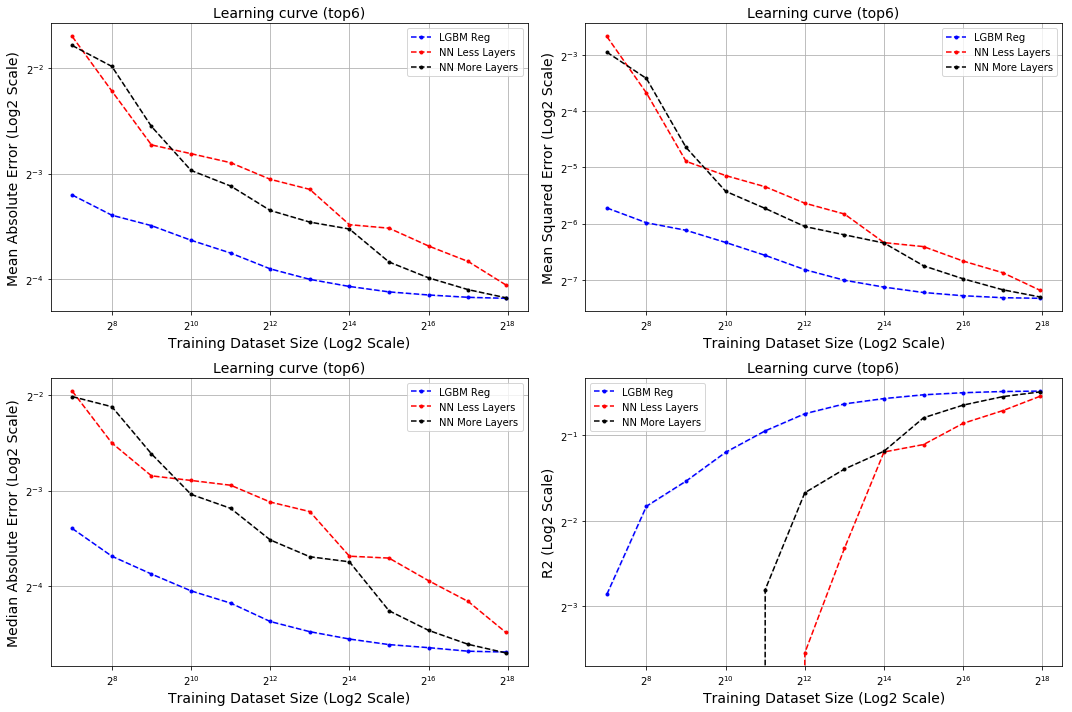

In [82]:
plot_all_metrics_from_runs(runs, metrics='all', title=None, figsize=(15,10), save=False)

In [264]:
# metric_name = 'mean_absolute_error'
# rslt, scores_df = load_scores(nn_less_layer_dir, metric_name=metric_name, cv_folds=1)
# rslt, scores_df = load_scores(nn_more_layer_dir, metric_name=metric_name, cv_folds=1)

# id0 = 0
# shard_min_idx = 0
# rslt[0], rslt[2] = rslt[0][shard_min_idx:], rslt[2][shard_min_idx:]
# x, y = get_xy(scores_df, metric_name=metric_name)
# x, y = x[shard_min_idx:], y[shard_min_idx:]

In [265]:
# # xtick_scale='linear'
# xtick_scale='log2'

# ax = lrn_crv.plot_lrn_crv(
#     rslt, metric_name=metric_name, ylim=None,
#     xtick_scale=xtick_scale, ytick_scale='linear',
#     title='nn_less_layer_dir');

# ax = lrn_crv.plot_lrn_crv(
#     rslt, metric_name=metric_name, ylim=None,
#     xtick_scale=xtick_scale, ytick_scale='linear',
#     title='nn_less_layer_dir', ax=ax);

# NNs with diff number of neurons

In [266]:
lgb_reg_dir         = maindir / 'top6.lgb_reg.cvf1.GE.DD.AUC_2019-9-22_h21-m18'
nn_less_neurons_dir = maindir / 'top6.nn_reg_n_less.sgd.cvf1.GE.DD.AUC_2019-9-20_h18-m48'
nn_more_neurons_dir = maindir / 'top6.nn_reg_n_more.sgd.cvf1.GE.DD.AUC_2019-9-20_h18-m48'

In [267]:
# src_name = 'gdsc'
src_name = 'top6'

# Top6
if src_name == 'top6':
    desc = [('LGBM Reg'      , lgb_reg_dir),
            ('NN Less Neurons', nn_less_neurons_dir),
            ('NN More Neurons', nn_more_neurons_dir)]    

runs = {}
for i, v in enumerate(desc):
    runs[f'run{i}'] = (v[0], v[1]/f'lrn_crv_scores.csv')

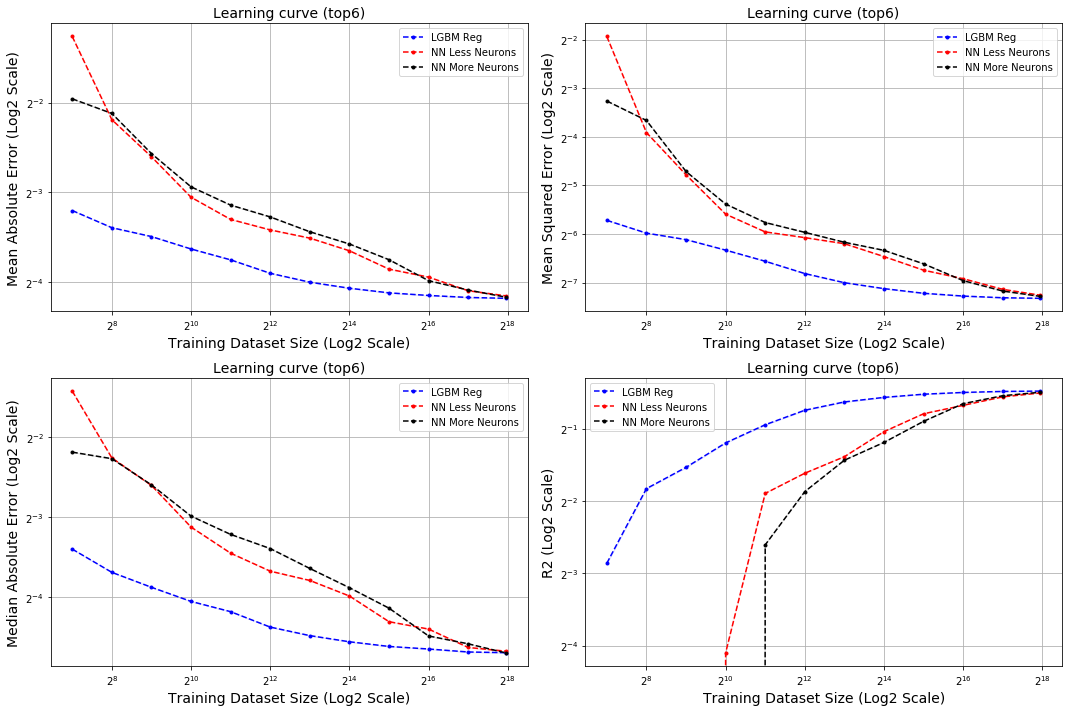

In [268]:
plot_all_metrics_from_runs(runs, metrics='all', title=None, figsize=(15,10), save=False)

# Explore the power-law curve

Generate a pair of plots that intersect.

In [149]:
def pwr_law(m, a, b, c):
    return a * np.power(m, b) + c

In [172]:
# m = np.linspace()
m = np.logspace(14, 20, num=21, base=2)
m[:7]

array([16384.        , 20171.07006824, 24833.50022571, 30573.62506668,
       37640.54769654, 46340.95001184, 57052.40171617])

In [261]:
# prms1 = {'a': 20, 'b': -0.3, 'c': 0.5}
# prms2 = {'a': 40, 'b': -0.3, 'c': 0.5}

# prms1 = {'a': 40, 'b': -0.3, 'c': 0.5}
# prms2 = {'a': 40, 'b': -0.6, 'c': 0.5}

# prms1 = {'a': 40, 'b': -0.3, 'c': 0.3}
# prms2 = {'a': 40, 'b': -0.3, 'c': 0.7}

prms1 = {'a': 20, 'b': -0.5, 'c': 0.06}  # lgb
prms2 = {'a': 40, 'b': -0.5, 'c': 0.05} # nn

# somewhat works!
# prms1 = {'a': 40, 'b': -0.5, 'c': 0.5}  # lgb
# prms2 = {'a': 100, 'b': -0.5, 'c': 0.3} # nn

y1 = pwr_law(m=m, **prms1)
y2 = pwr_law(m=m, **prms2)
# y1[:5]

In [262]:
xtick_scale = 'linear'
ytick_scale = 'linear'

# Set axes scale and labels
basex, xlabel_scale = lrn_crv.scale_ticks_params(tick_scale=xtick_scale)
basey, ylabel_scale = lrn_crv.scale_ticks_params(tick_scale=ytick_scale)

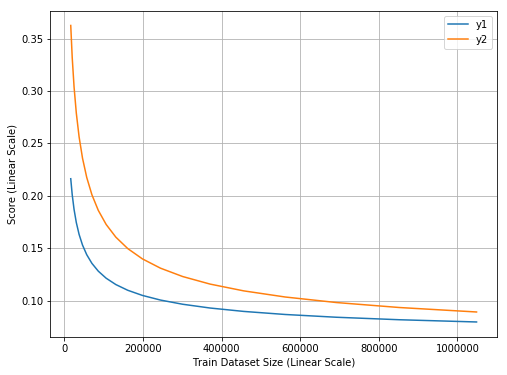

In [263]:
_, ax = plt.subplots(figsize=(8,6))
ax.plot(m, y1, label='y1')
ax.plot(m, y2, label='y2')

ax.set_xlabel(f'Train Dataset Size ({xlabel_scale})')
if 'log' in xlabel_scale.lower(): ax.set_xscale('log', basex=basex)

ax.set_ylabel(f'Score ({ylabel_scale})')
if 'log' in ylabel_scale.lower(): ax.set_yscale('log', basey=basey)
    
ax.legend(loc='best', frameon=True)    
ax.grid(True)

In [257]:
xtick_scale = 'log2'
ytick_scale = 'log2'

# Set axes scale and labels
basex, xlabel_scale = lrn_crv.scale_ticks_params(tick_scale=xtick_scale)
basey, ylabel_scale = lrn_crv.scale_ticks_params(tick_scale=ytick_scale)

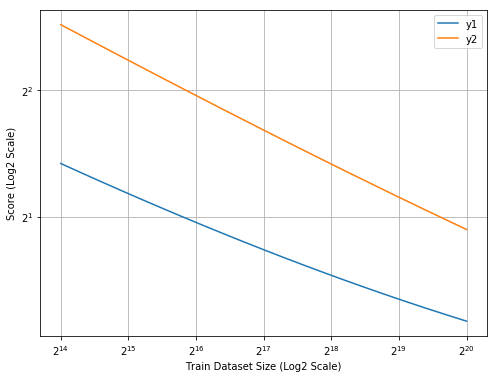

In [241]:
_, ax = plt.subplots(figsize=(8,6))
ax.plot(m, y1, label='y1')
ax.plot(m, y2, label='y2')

ax.set_xlabel(f'Train Dataset Size ({xlabel_scale})')
if 'log' in xlabel_scale.lower(): ax.set_xscale('log', basex=basex)

ax.set_ylabel(f'Score ({ylabel_scale})')
if 'log' in ylabel_scale.lower(): ax.set_yscale('log', basey=basey)
    
ax.legend(loc='best', frameon=True)    
ax.grid(True)